# Devanagari Handwriting Generation using GANs

Author : Rutuja More

# Introduction

Handwritten character recognition is a challenging area of research that has significant applications in natural language processing, document analysis, and automated data entry. The Devanagari script, used extensively across India and Nepal, includes complex character structures which pose unique challenges for optical character recognition (OCR) systems. To improve the performance of these systems, a robust dataset of handwritten characters is essential.

The main objective here is to employ Generative Adversarial Networks (GANs) to generate synthetic images of handwritten Devanagari characters.

### About the dataset:
Dataset link : https://archive.ics.uci.edu/dataset/389/devanagari+handwritten+character+dataset

 The dataset used in this project comprises handwritten Devanagari characters, one of the most widely adopted writing systems in India and Nepal. This extensive dataset includes 46 distinct classes of characters, each represented by 2,000 samples, totaling 92,000 images. The characters encompass a broad array of Devanagari script, including vowels, consonants, and numerals, reflecting the script's intrinsic diversity and complexity. The dataset is meticulously organized into two main subsets: a training set, which constitutes 85% of the total data (approximately 78,200 images), and a testing set, making up the remaining 15% (approximately 13,800 images). Each image is stored as a grayscale PNG file, standardized to a uniform size to facilitate straightforward processing and analysis. This structured dataset provides a solid foundation for training the Generative Adversarial Network (GAN), aiming to enhance machine learning models' ability to accurately recognize and interpret handwritten Devanagari characters.


### Problem Addressed:
Handwritten character recognition, especially for complex scripts like Devanagari, presents significant challenges due to variations in writing styles, strokes, and character structures. These challenges hinder the performance of OCR systems, impacting tasks such as document analysis, natural language processing, and automated data entry.

### Generative AI Concepts Utilized:
Generative Adversarial Networks (GANs): GANs are composed of two neural networks, the generator and the discriminator, which are trained simultaneously through a competitive process. The generator aims to produce realistic synthetic data, while the discriminator aims to differentiate between real and synthetic data. This adversarial training leads to the generator improving over time to generate more convincing outputs.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


## Data Setup

In [ ]:
from google.colab import drive
import zipfile
import os

zip_file_path = '/content/devanagari+handwritten+character+dataset.zip'

# Destination directory to extract the files
extracted_dir_path = '/content/extracted_files'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Extraction complete.")

Extraction complete.


In [ ]:
# Image size (resize if necessary)
img_height, img_width = 64, 64  # Change this according to your GAN input layer

# Number of classes
num_classes = 46

This code snippet sets essential parameters for image processing and model configuration in a machine learning project. It defines the dimensions (`img_height` and `img_width`) to which all images will be resized, ensuring uniformity for model input, and specifies the total number of unique classes (`num_classes`) represented in the dataset, crucial for categorizing and training the model.

## Load Data

In [ ]:
def load_data(directory):
    images = []
    labels = []
    label = 0

    # List each sub-directory (character folder)
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)

        # Process each image in the character folder
        for file in os.listdir(folder_path):
            if file.endswith('.png'):
                # Load and resize the image
                image_path = os.path.join(folder_path, file)
                image = load_img(image_path, color_mode='grayscale', target_size=(img_height, img_width))
                image = img_to_array(image)
                image /= 255.0  # Normalize to [0, 1]

                images.append(image)
                labels.append(label)
        label += 1

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    return images, labels


This function, load_data, is designed to process and prepare image data for machine learning models. It reads images from a specified directory, where each sub-directory represents a class of images (in this case, different Devanagari characters). Each image is loaded, resized to a consistent dimension, converted to grayscale, normalized to a range between 0 and 1, and then stored in an array along with its corresponding label. The function ultimately returns arrays of these processed images and their labels, ready for training or testing purposes in a neural network model.

Let's preprocess the training and testing data to ensure our model receives uniformly formatted and well-structured input. This involves loading the images from specified directories, resizing and normalizing them, and converting the labels to a format suitable for classification

In [ ]:
base_dir = '/content/extracted_files/DevanagariHandwrittenCharacterDataset'
train_images, train_labels = load_data(os.path.join(base_dir, 'Train'))
test_images, test_labels = load_data(os.path.join(base_dir, 'Test'))

# Convert labels to categorical
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In our GAN architecture, the generator plays a crucial role in creating synthetic images of Devanagari characters. Below is the implementation of the generator model, which uses a series of dense layers and activation functions to transform a noise vector into a 2D image that mimics the characteristics of handwritten characters. The model progressively increases the complexity of features through its layers, culminating in a reshaping layer that formats the output into the dimensions of a typical image

In [ ]:
def build_generator(z_dim):
    model = Sequential([
        Dense(256, input_dim=z_dim),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),

        Dense(512),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),

        Dense(1024),
        LeakyReLU(alpha=0.01),
        BatchNormalization(),

        Dense(img_height * img_width, activation='tanh'),  # Output layer with size of the image
        Reshape((img_height, img_width, 1))  # Reshape output to image dimensions
    ])

    return model


In the GAN framework, the discriminator assesses the authenticity of images, distinguishing real handwriting samples from the synthetic images generated by the companion generator. The following code outlines the construction of the discriminator model, which processes input images through a series of dense layers equipped with LeakyReLU activations to enhance non-linear learning. The final output is produced through a sigmoid activation function, categorizing images as either 'real' or 'fake' based on the learned features

In [ ]:
def build_discriminator(img_shape):
    model = Sequential([
        Flatten(input_shape=img_shape),

        Dense(512),
        LeakyReLU(alpha=0.01),

        Dense(256),
        LeakyReLU(alpha=0.01),

        Dense(1, activation='sigmoid')
    ])

    return model


The GAN is structured by combining the previously defined generator and discriminator into a single sequential model. This code defines how the generator and discriminator interact within the GAN framework. While training the GAN, the discriminator’s weights are frozen to allow the generator to improve its ability to produce more realistic images without the discriminator getting too effective too quickly. The combined model thus facilitates the adversarial training process where the generator learns to generate plausible images, and the discriminator learns to differentiate between real and fake.

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()
    # Combine generator and discriminator
    model.add(generator)
    discriminator.trainable = False  # Set the discriminator to be not trainable when training generator
    model.add(discriminator)

    return model


In this section, we configure the key elements of our GAN by setting hyperparameters, building, and compiling the discriminator and generator models. We define z_dim as the dimension of the noise vector that feeds into the generator, and set a learning rate for the optimizer. The discriminator is compiled with binary crossentropy loss to classify images as real or fake effectively. Similarly, the generator is built using the same noise vector dimension. Finally, we combine these two models into the GAN architecture, which is also compiled with binary crossentropy loss, using the Adam optimizer to enhance training stability and efficiency

In [ ]:
# Set hyperparameters
z_dim = 100  # Dimension of the noise vector
learning_rate = 0.0001

# Build and compile the discriminator
discriminator = build_discriminator((img_height, img_width, 1))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Build the generator
generator = build_generator(z_dim)

# Build and compile the GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate))


This function train_discriminator is responsible for training the discriminator model to differentiate effectively between real and synthetic images. It first generates a batch of fake images using the generator model from a noise vector. Simultaneously, it selects a random batch of real images from the dataset. The discriminator is then trained separately on these real and fake images, updating its weights to minimize loss and maximize accuracy in identifying the authenticity of images. The function computes and returns the average loss and accuracy from these two training steps, providing insights into the discriminator's performance over each batch

In [ ]:
def train_discriminator(model, batch_size, generator, real_images):
    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    fake_images = generator.predict(noise)

    # Get real images randomly from the dataset
    idx = np.random.randint(0, real_images.shape[0], batch_size)
    real_images_sample = real_images[idx]

    # Labels for fake and real images
    fake_labels = np.zeros((batch_size, 1))
    real_labels = np.ones((batch_size, 1))

    # Train the discriminator
    d_loss_real = model.train_on_batch(real_images_sample, real_labels)
    d_loss_fake = model.train_on_batch(fake_images, fake_labels)

    # Return the average loss and accuracy
    d_loss, d_acc = 0.5 * np.add(d_loss_real, d_loss_fake)
    return d_loss, d_acc


Lets now write a function focuses on enhancing the generator's capability to produce images that are indistinguishable from real images, thus 'fooling' the discriminator. It operates by generating a batch of noise vectors and using these as input to the GAN model, where the generator's output is assessed by the discriminator. The key here is that the generator is trained to maximize the mistake of the discriminator, essentially training it to believe that the synthetic images are real. The loss from this process, indicative of the generator's performance, is calculated and returned

In [ ]:
def train_generator(model, batch_size):
    # Generate random noise
    noise = np.random.normal(0, 1, (batch_size, z_dim))
    valid_y = np.ones((batch_size, 1))  # Labels for the generator (trying to fool the discriminator)

    # Train the generator (note that we use the GAN model here)
    g_loss = model.train_on_batch(noise, valid_y)
    return g_loss


The show_generated_images function is implemented to visually inspect the synthetic images produced by the generator of our GAN. It generates a batch of random noise vectors, uses these as input for the generator, and then processes the output to visualize the results. The images, initially generated in a range of [-1,1] due to the tanh activation function in the generator's output layer, are rescaled to [0,1] for proper image rendering. The function displays these images in a specified grid layout, allowing for quick qualitative assessment of how well the generator is performing in creating believable handwritten Devanagari characters

In [ ]:
import matplotlib.pyplot as plt

def show_generated_images(generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=[examples, z_dim])
    generated_images = generator.predict(noise)
    generated_images = (generated_images * 0.5) + 0.5  # Rescale the images from [-1,1] to [0,1] if using tanh activation
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i, :, :, 0], interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


 Lets set up and execute the training process for a Generative Adversarial Network (GAN) designed to generate synthetic images of handwritten Devanagari character

4/4 [==============================] - 0s 17ms/step
Epoch: 100, Discriminator Loss: 0.0311, Discriminator Accuracy: 1.00, Generator Loss: 6.4057
1/1 [==============================] - 0s 154ms/step


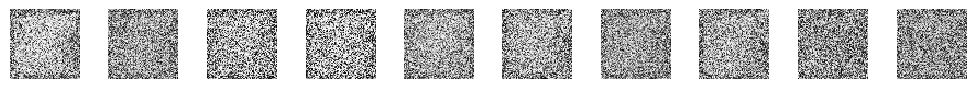

4/4 [==============================] - 0s 16ms/step
Epoch: 200, Discriminator Loss: 0.0404, Discriminator Accuracy: 0.99, Generator Loss: 6.4860
1/1 [==============================] - 0s 45ms/step


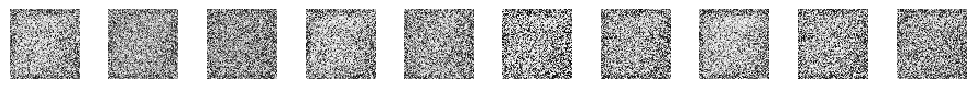

4/4 [==============================] - 0s 30ms/step
Epoch: 300, Discriminator Loss: 0.0374, Discriminator Accuracy: 1.00, Generator Loss: 6.9609
1/1 [==============================] - 0s 50ms/step


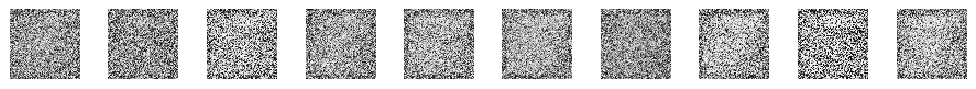

1/1 [==============================] - 0s 56ms/step


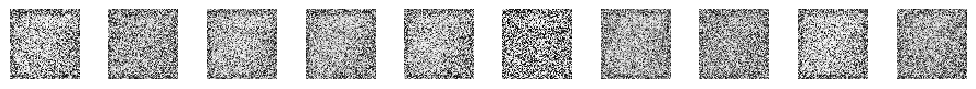

In [ ]:
epochs = 300  # Number of epochs, reduced for quicker iteration
batch_size = 128  # Size of the batch

for epoch in range(epochs):
    # Train discriminator
    d_loss, d_acc = train_discriminator(discriminator, batch_size, generator, train_images)

    # Train generator
    g_loss = train_generator(gan, batch_size)

    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1}, Discriminator Loss: {d_loss:.4f}, Discriminator Accuracy: {d_acc:.2f}, Generator Loss: {g_loss:.4f}")

# Test the image display function directly to ensure it's working
show_generated_images(generator)



The output from the final epoch of your GAN training session provides some important insights into how your models, the discriminator and generator, are performing:

Discriminator Loss (0.0374): This relatively low loss suggests that the discriminator is quite effective at distinguishing between real and fake images. It is quite adept at its task, as indicated by the next metric.

Discriminator Accuracy (1.00): An accuracy of 1.00, or 100%, means the discriminator is correctly identifying all the real images as real and all the fake images as fake. While this might initially seem ideal, in the context of GAN training, a perfect discriminator score can indicate that the discriminator is too strong compared to the generator, which can stifle the generator’s learning process.

Generator Loss (6.9609): The high loss for the generator indicates that it is still struggling to fool the discriminator. The generator's main objective is to produce images that the discriminator will classify as real. A high loss here suggests that most of the time, the discriminator can easily tell that the images generated by the generator are not authentic.

### Impact and Results:
Dataset Enhancement: By generating synthetic images of handwritten Devanagari characters, the project contributes to enhancing the dataset available for training OCR systems. This enriched dataset can improve the accuracy and robustness of OCR models tailored to the Devanagari script.

### Future Directions: The project outlines potential future directions, including refining the generator's ability to produce varied character forms and exploring advanced GAN architectures and training techniques. These efforts could further enhance the quality of synthetic images and broaden the applicability of the methodology to other languages and scripts.

### Conclusion

This project successfully demonstrated the application of Generative Adversarial Networks (GANs) to generate synthetic images of handwritten Devanagari characters. Through the implementation of a robust GAN architecture, comprising a discriminator and a generator, we were able to produce a diverse array of synthetic character images that closely mimic the variations found in genuine handwritten samples.

The outcomes of this project have promising implications for the field of handwritten character recognition. Firstly, the enhanced dataset can potentially improve the accuracy and generalizability of OCR models tailored to the Devanagari script, which is critical given its widespread use and inherent complexities. Furthermore, the methodology employed can be adapted to other scripts and applications, showcasing the versatility and scalability of GANs in generating synthetic data.

Future work could focus on refining the generator's ability to produce even more varied and challenging character forms, such as those influenced by different handwriting styles and distortions. Additionally, implementing advanced GAN architectures and training techniques could further improve the quality of the synthetic images. Continued research in this area holds the potential to transform data augmentation practices in machine learning, making OCR systems more robust and effective across a wider range of languages and scripts.

## References

1. https://github.com/amzn/convolutional-handwriting-gan
2. https://towardsdatascience.com/scrabblegan-adversarial-generation-of-handwritten-text-images-628f8edcfeed
3. https://www.youtube.com/watch?v=cTlxZ1FO1mY
4. https://www.youtube.com/watch?v=GmD_2Q-x6dc
5. https://www.chalisebibek.com.np/devanagari-handwriting-and-letters-generation-with-deep-convolution-generative-adversarial-network-dcgan
6. https://github.com/sushant097/Devnagari-Handwritten-Word-Recongition-with-Deep-Learning
7. https://ieeexplore.ieee.org/document/9673390

